In this jupyter notebook, we show how EP3.0 can be used with any custom dataloader through fit_batch() module.
Here we create a pytorch data loader for Fashion MNIST data set.

First we create dataset and dataloader to visualize the dataset:

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.ToTensor()])
trainset_tmp = datasets.FashionMNIST('~/', download=True, train=True, transform=transform)
trainloader_tmp = torch.utils.data.DataLoader(trainset_tmp, batch_size=10_000, shuffle=True)

/home/amirhesam/research/kernel/venv_ker/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


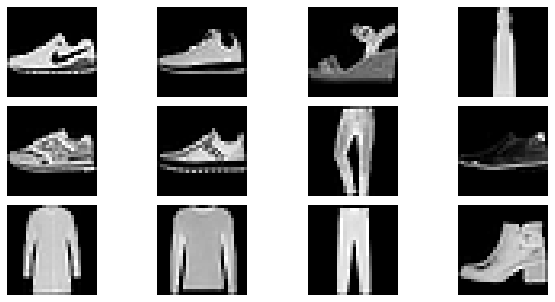

In [2]:
plot_size = 2
fig, ax = plt.subplots(3, 4, figsize=(4*plot_size, 2*plot_size))
for i in range(12):
    image, label = next(iter(trainloader_tmp))
    ax[i//4][i%4].imshow(torch.squeeze(image[i,:]),cmap='gray')
    ax[i//4][i%4].axis('off')
    
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=.1)
plt.show()

Loading necessary packages from EP3.0:

In [3]:
from eigenpro3.utils import accuracy, load_dataset
from eigenpro3.datasets import CustomDataset
from eigenpro3.models import KernelModel
from eigenpro3.kernels import laplacian, ntk_relu
from eigenpro3.utils import accuracy,bottomrule, midrule 
from torch.nn.functional import one_hot
import copy

In [4]:
if torch.cuda.is_available():
    DEVICES = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
else:
    DEVICES = [torch.device('cpu')]
    
kernel_fn = lambda x, z: laplacian(x, z, bandwidth=5.0)
p = 5_000
s = 10_000
n_classes = 10


centers = trainset_tmp.data[torch.randperm(trainset_tmp.data.shape[0])[:p]].reshape(-1,28*28)/255.0
nystrom_samples = trainset_tmp.data[torch.randperm(trainset_tmp.data.shape[0])[:s]].reshape(-1,28*28)/255.0


model= KernelModel(n_classes, centers, kernel_fn, nystrom_samples=nystrom_samples,make_dataloader=False,
    devices = DEVICES, 
    multi_gpu=True)


##### creating new dataloader using optimal batchsize calculated based on Nystrom
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,)),transforms.Lambda(lambda x: torch.flatten(x))])
trainset = datasets.FashionMNIST('~/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=model.batch_size, shuffle=True)
testset = datasets.FashionMNIST('~/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)


Setting up data preconditioner
Data: learning rate: 3629.5,batch_size=7259, top eigenvalue:0.12390097975730896, new top eigenvalue:0.00013775394472759217
Data preconditioner is ready.
Setup time = 11.58 s
Done.
Setting up inexact projector
Done.
-------------------------


In [ ]:
iterations = 15
epoch = 0
accu_all = []
for _ in range(iterations):  
    batch_num = 0
    for (X_batch, y_batch) in trainloader:
        X_batch = X_batch 
        y_batch = one_hot(y_batch)
        ###### fitting the batch
        model.fit_batch(X_batch, y_batch)
        model.sync_gpus()
        torch.cuda.empty_cache()
        if (batch_num + 1)%2==0:
            print(f'epoch {epoch: 4d}\t batch {batch_num+1 :4d}')
        batch_num += 1
        del  X_batch, y_batch
    
    
    accu = accuracy(model.weights,model.centers,testloader,model.kernel,model.device_base)
    print(midrule)
    print(f'epoch {epoch+1:4d}        Test accuracy: {accu*100.:5.2f}%')
    accu_all.append(accu.item())
    print(bottomrule)
    epoch +=1

epoch    0	 batch    2
epoch    0	 batch    4
epoch    0	 batch    6
epoch    0	 batch    8
-------------------------
epoch    1        Test accuracy: 71.25%
epoch    1	 batch    2
epoch    1	 batch    4
epoch    1	 batch    6
epoch    1	 batch    8
-------------------------
epoch    2        Test accuracy: 73.07%
epoch    2	 batch    2
epoch    2	 batch    4
epoch    2	 batch    6
epoch    2	 batch    8
-------------------------
epoch    3        Test accuracy: 74.14%


In [ ]:
plot_size = 2
fig, ax = plt.subplots(1, 1, figsize=(plot_size, plot_size))
ax.plot(range(len(accu_all)),accu_all_augment.cpu())
ax.set_xlabel('epoch')
ax.set_ylabel('Test accuracy')


At the end, note that pytorch dataloader is slow, and we suggest to use simple batching techniques using manual methods. We provided the dataloader based on pytorch since it is widely used. However, to run large-scale experiments we recommend to avoid pytroch dataloader.